In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../My projects/Data/heart-disease.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


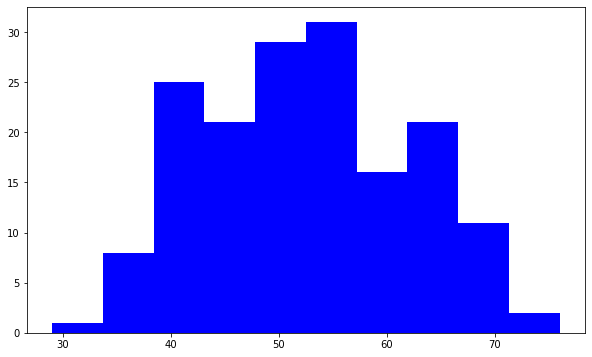

In [4]:
fig,ax = plt.subplots(figsize=(10,6))
ax = plt.hist(df.age[df.target==1],color='blue')

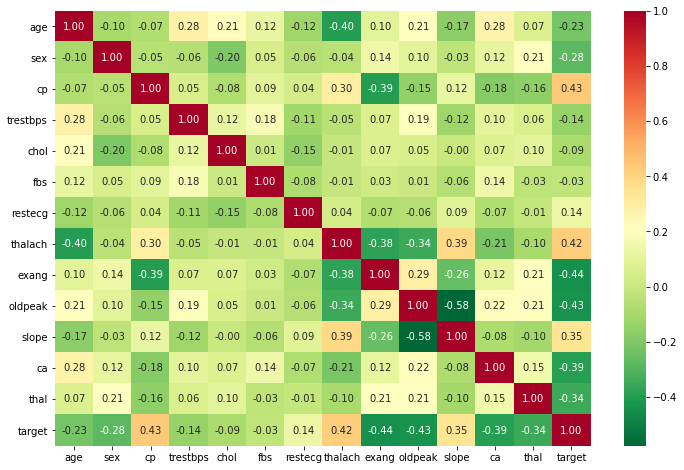

In [5]:
corr = df.corr()
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(corr,color ='blue',
                 annot = True,
                 fmt = '.2f',
                 cmap='RdYlGn_r')

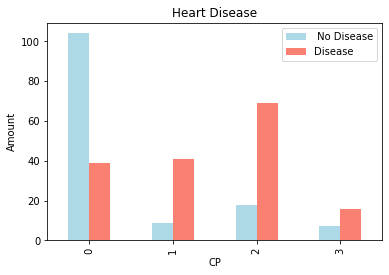

In [6]:
pd.crosstab(df.cp, df.target).plot(kind='bar',
                                  color = ['lightblue', 'salmon']);
plt.title('Heart Disease')
plt.xlabel('CP')
plt.ylabel('Amount')
plt.legend([' No Disease', 'Disease'])

## Modeling

In [7]:
X = df.drop('target', axis=1)
y = df['target']

In [8]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)



In [9]:
from sklearn.linear_model import LogisticRegression
models = {'Log Regression': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'Random Forest': RandomForestClassifier()}

def fit_and_score(models,X_train, X_test, y_train, y_test):
    
    # Set random seed
    np.random.seed(42)
    
    model_scores = {}
    for name,model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = round(model.score(X_test, y_test),3)
    return model_scores


In [10]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores

{'Log Regression': 0.885, 'KNN': 0.689, 'Random Forest': 0.836}

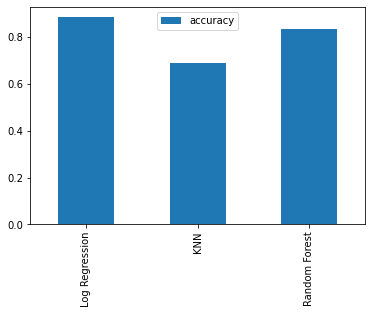

In [11]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

In [12]:
# Let's tuning hyperparameter
train_scores = []
test_scores = []

neighbors = range(1,21)

knn = KNeighborsClassifier()

for n in neighbors:
    knn.set_params(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    
    train_scores.append(knn.score(X_train, y_train))
    
    test_scores.append(knn.score(X_test,y_test))

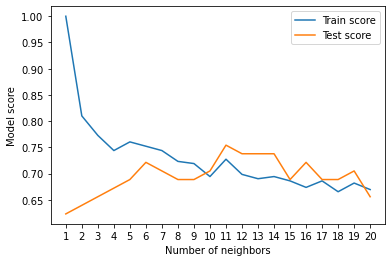

In [13]:
plt.plot(neighbors, train_scores, label = 'Train score')
plt.plot(neighbors, test_scores, label = 'Test score')
plt.xticks(np.arange(1,21,1))
plt.xlabel('Number of neighbors')
plt.ylabel("Model score")
plt.legend()


In [14]:
# So, KNN - get out)
log_reg_grid =  {'C': np.logspace(-4,4, 20), # is it for log_reg
                'solver': ['liblinear']}

rf_grid = {'n_estimators': np.arange(10,1000,50),
          'max_depth': [None,3,5,10],
          'min_samples_split': np.arange(2,20,2),
          'min_samples_leaf': np.arange(1,20,2)}

In [15]:
%%time
np.random.seed(42)
from sklearn.model_selection import RandomizedSearchCV
rs_log_reg = RandomizedSearchCV(LogisticRegression(),param_distributions=log_reg_grid,
                               cv=5, n_iter=20, verbose=True)

rs_log_reg.fit(X_train,y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 699 ms, sys: 448 µs, total: 699 ms
Wall time: 697 ms


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [16]:
rs_log_reg.best_params_


{'solver': 'liblinear', 'C': 0.23357214690901212}

In [17]:
rs_log_reg.score(X_test,y_test)

0.8852459016393442

In [18]:
%%time
# let's tunde RandomForestClassifier

np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv = 5 ,
                          n_iter=50,
                          verbose=True)

rs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.2min finished


CPU times: user 3min 11s, sys: 574 ms, total: 3min 11s
Wall time: 3min 11s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [19]:
rs_rf.best_params_

{'n_estimators': 260,
 'min_samples_split': 16,
 'min_samples_leaf': 17,
 'max_depth': 3}

In [20]:
rs_rf.score(X_test,y_test)

0.8688524590163934

In [25]:
%%time
from sklearn.model_selection import GridSearchCV
log_reg_grid = {'C': np.logspace(-4,4,30),
               'solver': ['liblinear', 'sag']}

gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid = log_reg_grid,
                         cv=5,verbose=True)

gs_log_reg.fit(X_train, y_train);
#gs_log_reg.score(X_test,y_test)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 3.31 s, sys: 0 ns, total: 3.31 s
Wall time: 3.32 s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear', 'sag']},
             verbose=True)

In [26]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [27]:
gs_log_reg.score(X_test,y_test)

0.8852459016393442

In [35]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, plot_roc_curve, recall_score,f1_score

y_preds = gs_log_reg.predict(X_test)

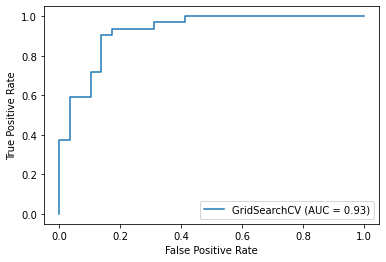

In [37]:
plot_roc_curve(gs_log_reg, X_test, y_test)

In [38]:
print(confusion_matrix(y_test,y_preds))

[[25  4]
 [ 3 29]]


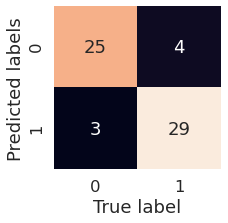

In [43]:
sns.set(font_scale=1.5)
def plot_conf_matr(y_test,y_preds):
    '''
    Plots a nice looking confusion matrix using Seaborn
    '''
    
    fig,ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap (confusion_matrix(y_test,y_preds),
                     annot = True,
                     cbar=False)
    
    plt.xlabel('True label')
    plt.ylabel('Predicted labels')
    
plot_conf_matr(y_test,y_preds)

In [44]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



In [45]:
## Calculate evaluation metrics using cross_val_score
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [73]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(C = 0.2043359,
                        solver = 'liblinear')
cv_acc = cross_val_score(clf, X, y,
                        cv = 5 , scoring = 'accuracy')
cv_acc = np.mean(cv_acc)

In [74]:
cv_precision = cross_val_score(clf, X, y,
                        cv = 5 , scoring = 'precision')
cv_precision = np.mean(cv_precision)

In [75]:
cv_recall = cross_val_score(clf, X, y,
                        cv = 5 , scoring = 'recall')
cv_recall = np.mean(cv_recall)

In [76]:
cv_f1 = cross_val_score(clf, X, y,
                        cv = 5 , scoring = 'f1')
cv_f1 = np.mean(cv_f1)

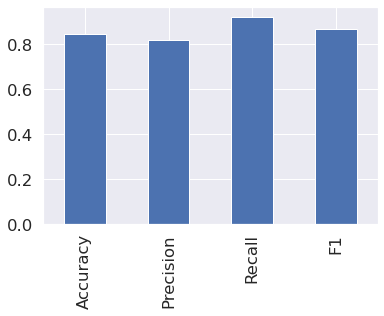

In [86]:
# plot cv-metrics
cv_metrics = pd.DataFrame({'Accuracy': cv_acc,
                          'Precision': cv_precision,
                          'Recall': cv_recall,
                          'F1': cv_f1},columns=['Accuracy', 'Precision', 'Recall', 'F1'],
                         index=[0])
# cv_metrics.T.plot.bar(legend=False)
cv_metrics.T.plot.bar(legend=False)


In [88]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [93]:
clf = LogisticRegression(C = 0.204,
                        solver = 'liblinear')
clf.fit(X_train, y_train)
clf.coef_

array([[ 0.00316039, -0.85987755,  0.66049168, -0.01156959, -0.00166321,
         0.04380091,  0.31251121,  0.02459174, -0.60378269, -0.56853877,
         0.45026147, -0.63591277, -0.67637049]])

In [96]:
feat_dict = dict(zip(df.columns, list(clf.coef_[0])))
feat_dict

{'age': 0.003160387924158638,
 'sex': -0.8598775484470369,
 'cp': 0.6604916843106192,
 'trestbps': -0.011569594031631951,
 'chol': -0.0016632067370350252,
 'fbs': 0.043800912045389655,
 'restecg': 0.31251120888424433,
 'thalach': 0.024591744271736736,
 'exang': -0.6037826910013518,
 'oldpeak': -0.568538767139446,
 'slope': 0.45026146837110365,
 'ca': -0.6359127746823107,
 'thal': -0.6763704905981709}

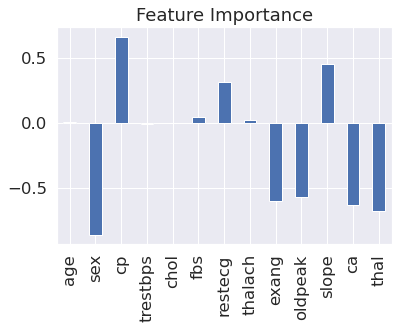

In [104]:
feat_df = pd.DataFrame(feat_dict, index=[0])
feat_df.T.plot.bar(title = 'Feature Importance' , legend = False);

In [106]:
pd.crosstab(df['sex'], df['target'])

target,0,1
sex,,
0,24,72
1,114,93


In [110]:
pd.crosstab(df['slope'], df['target'])

target,0,1
slope,,
0,12,9
1,91,49
2,35,107
